In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors

## Preprocess

In [2]:
data = pd.read_csv('project_data.csv')
data.drop(columns=['X Coordinate', 'Y Coordinate', 'Year', 'Updated On', 'IUCR', 'Case Number', 'Description'], inplace=True)

temperatures = pd.read_csv('data/daily_chicago_weather_2022.csv')

In [3]:
def fahrenheit_to_celsius(temp):
    return (temp - 32) * 5 / 9

seasons_dict = {
    'Winter': [12, 1, 2],
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Fall': [9, 10, 11]
}

locations_mapping = {
    'RESIDENCE': 'RESIDENCE',
    'APARTMENT': 'RESIDENCE',
    'STREET': 'STREET',
    'COMMERCIAL / BUSINESS OFFICE': 'OFFICE',
    'HOSPITAL BUILDING / GROUNDS': 'HOSPITAL',
    'WAREHOUSE': 'WAREHOUSE',
    'VEHICLE - COMMERCIAL': 'VEHICLE',
    'SCHOOL - PUBLIC GROUNDS': 'SCHOOL',
    'OTHER (SPECIFY)': 'OTHER',
    'GOVERNMENT BUILDING / PROPERTY': 'GOVERNMENT_PROPERTY',
    'RESIDENCE - PORCH / HALLWAY': 'RESIDENCE',
    'SIDEWALK': 'STREET',
    'PARKING LOT / GARAGE (NON RESIDENTIAL)': 'PARKING_LOT',
    'BANK': 'BANK',
    'ALLEY': 'STREET',
    'POLICE FACILITY / VEHICLE PARKING LOT': 'POLICE FACILITY',
    'MOVIE HOUSE / THEATER': 'THEATER',
    'VEHICLE NON-COMMERCIAL': 'VEHICLE',
    'OTHER RAILROAD PROPERTY / TRAIN DEPOT': 'PUBLIC_TRANSPORT',
    'SCHOOL - PUBLIC BUILDING': 'SCHOOL',
    'DAY CARE CENTER': 'DAY CARE CENTER',
    'VEHICLE - OTHER RIDE SHARE SERVICE (LYFT, UBER, ETC.)': 'VEHICLE',
    'BAR OR TAVERN': 'BAR',
    'CTA PLATFORM': 'PUBLIC_TRANSPORT',
    'AUTO / BOAT / RV DEALERSHIP': 'OFFICE',
    'SMALL RETAIL STORE': 'STORE',
    'GAS STATION': 'GAS STATION',
    'RESIDENCE - YARD (FRONT / BACK)': 'RESIDENCE',
    'RESTAURANT': 'BUSINESSES',
    'PARKING LOT': 'PARKING LOT',
    'VACANT LOT / LAND': 'VACANT',
    'BARBERSHOP': 'BUSINESSES',
    'CTA BUS STOP': 'PUBLIC_TRANSPORT',
    'RESIDENCE - GARAGE': 'RESIDENCE',
    'HOUSE': 'RESIDENCE',
    'HOTEL / MOTEL': 'HOTEL',
    'DEPARTMENT STORE': 'BUSINESSES',
    'ATM (AUTOMATIC TELLER MACHINE)': 'ATM',
    'JAIL / LOCK-UP FACILITY': 'JAIL',
    'ABANDONED BUILDING': 'VACANT',
    'DRIVEWAY - RESIDENTIAL': 'RESIDENCE',
    'PARK PROPERTY': 'PARK',
    'FEDERAL BUILDING': 'GOVERNMENT_PROPERTY',
    'CLEANING STORE': 'BUSINESSES',
    'MEDICAL / DENTAL OFFICE': 'BUSINESSES',
    'ATHLETIC CLUB': 'SPORT',
    'FACTORY / MANUFACTURING BUILDING': 'FACTORY',
    'CONVENIENCE STORE': 'BUSINESSES',
    'CONSTRUCTION SITE': 'OTHER',
    'CURRENCY EXCHANGE': 'CURRENCY_EXCHANGE',
    'GROCERY FOOD STORE': 'BUSINESSES',
    'AIRPORT PARKING LOT': 'PARKING_LOT',
    'CHURCH / SYNAGOGUE / PLACE OF WORSHIP': 'RELIGIOUS',
    'DRUG STORE': 'MEDICAL',
    'APPLIANCE STORE': 'BUSINESSES',
    'SPORTS ARENA / STADIUM': 'SPORT',
    'CHA APARTMENT': 'RESIDENCE',
    'AIRPORT TERMINAL UPPER LEVEL - SECURE AREA': 'AIRPORT',
    'OTHER COMMERCIAL TRANSPORTATION': 'PUBLIC_TRANSPORT',
    'CREDIT UNION': 'OTHER',
    'AIRPORT EXTERIOR - NON-SECURE AREA': 'AIRPORT',
    'CTA BUS': 'PUBLIC_TRANSPORT',
    'AIRPORT VENDING ESTABLISHMENT': 'AIRPORT',
    'BOWLING ALLEY': 'BUSINESSES',
    'SCHOOL - PRIVATE GROUNDS': 'SCHOOL',
    'AIRPORT/AIRCRAFT': 'AIRPORT',
    'NURSING / RETIREMENT HOME': 'RETIREMENT_HOME',
    'AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA': 'AIRPORT',
    'TAVERN / LIQUOR STORE': 'BAR',
    'SCHOOL - PRIVATE BUILDING': 'SCHOOL',
    'AIRPORT TERMINAL LOWER LEVEL - NON-SECURE AREA': 'AIRPORT',
    'CAR WASH': 'BUSINESSES',
    'CTA TRAIN': 'PUBLIC_TRANSPORT',
    'CHA PARKING LOT / GROUNDS': 'PARKING_LOT',
    'LIBRARY': 'BUSINESSES',
    'AIRPORT TERMINAL UPPER LEVEL - NON-SECURE AREA': 'AIRPORT',
    'FIRE STATION': 'PUBLIC_BUILDING',
    'CTA STATION': 'PUBLIC_TRANSPORT',
    'GARAGE': 'BUSINESSES',
    'TAVERN': 'BAR',
    'COLLEGE / UNIVERSITY - RESIDENCE HALL': 'PUBLIC_BUILDING',
    'YARD': 'PARK',
    'AUTO': 'OTHER',
    'AIRPORT BUILDING NON-TERMINAL - SECURE AREA': 'AIRPORT',
    'BOAT / WATERCRAFT': 'VEHICLE',
    'VESTIBULE': 'OTHER',
    'LAKEFRONT / WATERFRONT / RIVERBANK': 'PARK',
    'AIRCRAFT': 'AIRCRAFT',
    'VEHICLE - DELIVERY TRUCK': 'VEHICLE',
    'PAWN SHOP': 'BUSINESSES',
    'PORCH': 'RESIDENCE',
    'CTA PROPERTY': 'PUBLIC_TRANSPORT',
    'HALLWAY': 'OTHER',
    'BANQUET HALL': 'PUBLIC_BUILDING',
    'RETAIL STORE': 'BUSINESSES',
    'CHA PARKING LOT': 'PARKING_LOT',
    'CTA "L" TRAIN': 'PUBLIC_TRANSPORT',
    'HOTEL': 'HOTEL',
    'SCHOOL YARD': 'SCHOOL',
    'VACANT LOT': 'VACANT',
    'CHA GROUNDS': 'VACANT',
    'GAS STATION DRIVE/PROP.': 'PUBLIC_BUILDING',
    'DRIVEWAY': 'PARKING_LOT',
    'BASEMENT': 'RESIDENCE',
    'BARBER SHOP/BEAUTY SALON': 'BUSINESSES',
    'CHA LOBBY': 'PUBLIC_BUILDING',
    'RAILROAD PROPERTY': 'PUBLIC_TRANSPORT',
    'POLICE FACILITY': 'POLICE',
    'RIVER BANK': 'PARK',
    'LIQUOR STORE': 'BAR',
    'OFFICE': 'OFFICE',
    'TRUCK': 'VEHICLE',
    'PUBLIC GRAMMAR SCHOOL': 'SCHOOL',
    'STAIRWELL': 'OTHER',
    'ANIMAL HOSPITAL': 'BUSINESSES',
    'CHA HALLWAY / STAIRWELL / ELEVATOR': 'OTHER',
    'CTA PARKING LOT / GARAGE / OTHER PROPERTY': 'PARKING_LOT',
    'TAXICAB': 'VEHICLE',
    'AIRPORT TERMINAL LOWER LEVEL - SECURE AREA': 'AIRPORT',
    'COLLEGE / UNIVERSITY - GROUNDS': 'PUBLIC_BUILDING',
    'BRIDGE': 'STREET',
    'AIRPORT EXTERIOR - SECURE AREA': 'AIRPORT',
    'COIN OPERATED MACHINE': 'ATM',
    'AIRPORT TERMINAL MEZZANINE - NON-SECURE AREA': 'AIRPORT',
    'POOL ROOM': 'BUSINESSES',
    'CTA TRACKS - RIGHT OF WAY': 'PUBLIC_TRANSPORT',
    'SAVINGS AND LOAN': 'BANK',
    'HIGHWAY / EXPRESSWAY': 'VEHICLE',
    'AIRPORT TRANSPORTATION SYSTEM (ATS)': 'AIRPORT',
    'FOREST PRESERVE': 'PARK',
    'VEHICLE - COMMERCIAL: TROLLEY BUS': 'VEHICLE',
    'CEMETARY': 'PUBLIC_BUILDING',
    'VEHICLE - COMMERCIAL: ENTERTAINMENT / PARTY BUS': 'VEHICLE',
    'FARM': 'RESIDENCE',
}

part_of_day_mapping = {
    '0': 'Night',
    '1': 'Night',
    '2': 'Night',
    '3': 'Night',
    '4': 'Night',
    '5': 'Night',
    '6': 'Morning',
    '7': 'Morning',
    '8': 'Morning',
    '9': 'Morning',
    '10': 'Morning',
    '11': 'Morning',
    '12': 'Afternoon',
    '13': 'Afternoon',
    '14': 'Afternoon',
    '15': 'Afternoon',
    '16': 'Afternoon',
    '17': 'Afternoon',
    '18': 'Evening',
    '19': 'Evening',
    '20': 'Evening',
    '21': 'Evening',
    '22': 'Evening',
    '23': 'Evening',
}

def date_to_season(date):
    month = int(date.split('/')[0])
    for season in seasons_dict.keys():
        if month in seasons_dict[season]:
            return season


def format_date(date_str):
    month, day, year = date_str.split('/')
    month = int(month)
    day = int(day)
    return f"{month}/{day}"



In [4]:
# Create a dictionary that maps each day to the average temperature
day_to_temp = {}
for index, row in temperatures.iterrows():
    day_to_temp[format_date(row['date'])] = row['temp_avg']


# Reformating the date for the data df
days = []
for index, row in data.iterrows():
    days.append(format_date(row['Date'].split(' ')[0]))

# Extracting the day from the date
data['day'] = pd.Series(days)

# Mapping the locations to a more general category
data['Location Description'] = data['Location Description'].apply(lambda x: locations_mapping[x] if x in locations_mapping else 'OTHER')
data.rename(columns={'Location Description': 'Location'}, inplace=True)

# Mapping the time of the day to a more general category
data['part_of_day'] = data['Date'].apply(lambda x: part_of_day_mapping[x.split(' ')[1].split(':')[0]])

# Extracting the hour from the date
data['hour'] = data['Date'].apply(lambda x: float(x.split(' ')[1].split(':')[0]) + float(x.split(' ')[1].split(':')[1]) / 60)

# Mapping the days to seasons and adding the temperature
data['season'] = data['Date'].apply(date_to_season)
data['temperature'] = data['day'].apply(lambda x: round(fahrenheit_to_celsius(day_to_temp[x]), 1))

In [5]:
# Normalizing the temperature and define treatment as Z-score > 1.5
seasons_temperature_stats = data.groupby(['season'])['temperature'].aggregate(['mean', 'std'])
seasons_mean = seasons_temperature_stats['mean']
seasons_std = seasons_temperature_stats['std']

data['normalized_temperature'] = data.apply(lambda x: (x['temperature'] - seasons_mean[x['season']]) / seasons_std[x['season']], axis=1)
data['T'] = data['normalized_temperature'] > 1.5

In [6]:
X = data.drop(columns=['ID', 'Date', 'Block', 'FBI Code', 'temperature', 'normalized_temperature', 'Arrest'])
y = data['Arrest']
T = data['T']

X['Beat'] = X['Beat'].astype(str)
X['District'] = X['District'].astype(str)
X['Ward'] = X['Ward'].astype(str)
X['Community Area'] = X['Community Area'].astype(str)
X = X.replace({'T': {True: 'True', False: 'False'}})

## ATE Calculations

In [7]:
# Split data
X_train, X_test, y_train, y_test, T_train, T_test = train_test_split(X, y, T, test_size=0.3, random_state=42)

def create_model(numeric_features, categorical_features):
    # Preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=3000))
    ])

    return model

### S-learner

In [8]:
# Identify categorical features (assuming X is a DataFrame)
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_features = X.select_dtypes(include=['number']).columns.tolist()
model = create_model(numeric_features, categorical_features)

# Fit the model
model.fit(X_train, y_train)

X_test_1 = X_test[X_test['T'] == 'True']
X_test_0 = X_test_1.replace({'T': {'True': 'False'}})

# Predict outcomes for both treated and control
y_pred_treated = model.predict_proba(X_test_1)[:, 1]
y_pred_control = model.predict_proba(X_test_0)[:, 1]

# Calculate the ATE
print(f'S-learner ATE: {round(np.mean(y_pred_treated - y_pred_control), 4)}')

S-learner ATE: 0.0062


### T-learner

In [9]:
# Split data by treatment group
t_learner_x = X.copy().drop(columns=['T'])
X_train_treated = X_train[T_train == 1]
y_train_treated = y_train[T_train == 1]
X_train_control = X_train[T_train == 0]
y_train_control = y_train[T_train == 0]

# Create and fit models for both treatment groups
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_features = X.select_dtypes(include=['number']).columns.tolist()

model_treated = create_model(numeric_features, categorical_features)
model_control = create_model(numeric_features, categorical_features)
model_treated.fit(X_train_treated, y_train_treated)
model_control.fit(X_train_control, y_train_control)

# Predict outcomes for both models
y_pred_treated = model_treated.predict_proba(X_test)[:, 1]
y_pred_control = model_control.predict_proba(X_test)[:, 1]

# Calculate the ATE
print(f'ATE (T-Learner): {round(np.mean(y_pred_treated - y_pred_control), 4)}')


ATE (T-Learner): 0.0297


### Matching

In [10]:
# Preprocess the entire dataset
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_features = X.select_dtypes(include=['number']).columns.tolist()

preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numeric_features),
            ('cat', OneHotEncoder(), categorical_features)
        ])
X_processed = preprocessor.fit_transform(X)

# Split data by treatment group
X_treated = X_processed[T == 1]
X_control = X_processed[T == 0]
y_treated = y[T == 1]
y_control = y[T == 0]

# Find nearest neighbors for treated units from control units
nn_treatment = NearestNeighbors(n_neighbors=1)
nn_treatment.fit(X_control)

# Find nearest neighbors for control units from treated units
nn_control = NearestNeighbors(n_neighbors=1)
nn_control.fit(X_treated)

# Match treated units to control units
distances_treated, indices_treated = nn_treatment.kneighbors(X_treated)
print(f'type(indices_treated): {type(indices_treated)}, indices_treated.shape: {indices_treated.shape}')
matched_controls = X_control[indices_treated.flatten()]
print(f'type(indices_treated): {type(indices_treated)}, indices_treated.shape: {indices_treated.shape}')

# Match control units to treated units
distances_control, indices_control = nn_control.kneighbors(X_control)
matched_treated = X_treated[indices_control.flatten()]

# Calculate the ATE
def calculate_ate(y_treated, y_control, matched_controls, matched_treated):
    # Calculate average treatment effect
    treatment_effects = np.mean(y_treated - y_control[indices_treated.flatten()])
    return treatment_effects

ate = calculate_ate(y_treated, y_control, matched_controls, matched_treated)
print(f'ATE (Matching): {ate}')

KeyboardInterrupt: 

## Plots

In [67]:
crimes_per_day = data.groupby(['day'])['ID'].aggregate('count')
arrests_percentage = data.groupby(['day'])['Arrest'].aggregate('mean')


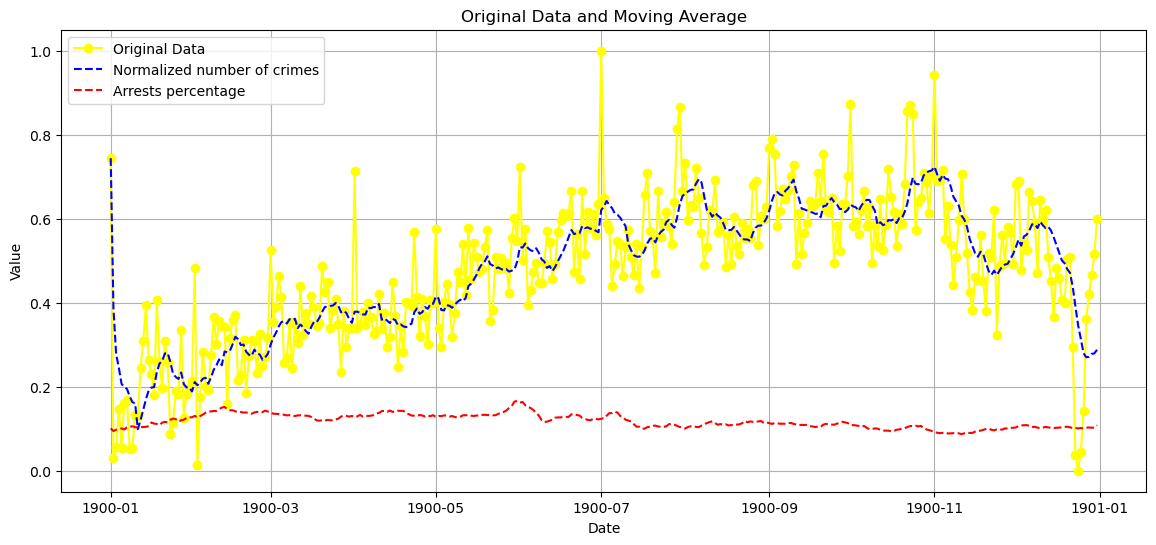

In [80]:
# Apply Min-Max normalization on the number of crimes per day
min_value = crimes_per_day.min()
max_value = crimes_per_day.max()
crimes_per_day_normalized = (crimes_per_day - min_value) / (max_value - min_value)


crimes_per_day_normalized.index = pd.to_datetime(crimes_per_day_normalized.index, format='%m/%d')
crimes_per_day_normalized = crimes_per_day_normalized.sort_index()


arrests_percentage.index = pd.to_datetime(arrests_percentage.index, format='%m/%d')
arrests_percentage = arrests_percentage.sort_index()

# Calculate moving average
window_length = 10
crimes_moving_avg = crimes_per_day_normalized.rolling(window=window_length, min_periods=1).mean()
arrests_moving_avg = arrests_percentage.rolling(window=window_length, min_periods=1).mean()

# Plot the results
plt.figure(figsize=(14,6))
plt.plot(crimes_per_day_normalized.index, crimes_per_day_normalized, label='Original Data', marker='o', color='yellow')
plt.plot(crimes_per_day_normalized.index, crimes_moving_avg, label='Normalized number of crimes', linestyle='--', color='blue')
plt.plot(arrests_percentage.index, arrests_moving_avg, label='Arrests percentage', linestyle='--', color='red')



# plt.xticks(
#     ticks=[0, 31, 59, 90, 120, 151, 181, 212, 334, 1000, 5000, 10000],
#     labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original Data and Moving Average')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()